<a href="https://colab.research.google.com/github/gshatko/urban_analytics/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install git+https://github.com/ValeriyaTikhevich/solver_FLP.git@main

  Cloning https://github.com/ValeriyaTikhevich/solver_FLP.git (to revision main) to /tmp/pip-req-build-sons_iki
  Running command git clone --filter=blob:none --quiet https://github.com/ValeriyaTikhevich/solver_FLP.git /tmp/pip-req-build-sons_iki
  Resolved https://github.com/ValeriyaTikhevich/solver_FLP.git to commit 16fc023ce6c9b33bd9931ccaa63e1546630c025a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 28.6 MB/s eta 0:00:00
  Created wheel for solver_FLP: filename=solver_flp-0.0.1-py3-none-any.whl size=9987 sha256=adb5285002e8942131d96809826054121d7f16c158fab76aa403ab52af1c2360
  Stored in directory: /tmp/pip-ephem-wheel-cache-xmiyjdlo/wheels/8f/9c/dd/929ec63c056f1997764422a596ab1993ca8f8d1d0f739fcc4c
Successfully built solver_FLP


In [7]:
from method import genetic_algorithm_main, choose_edges, fitness_plot

In [8]:

from method import genetic_algorithm_main, choose_edges, fitness_plot, block_coverage, services_plot, connect_blocks_plot
import os
import pandas as pd
import geopandas as gpd
import numpy as np

local_crs = 32636
example_data_path = "./data/"

import warnings
warnings.filterwarnings("ignore")

In [12]:
accessibility_matrix = pd.read_pickle(os.path.join("/data/data_getter_matrix.pickle"))
df_with_demand = gpd.read_file(os.path.join("/data/df_with_demand.geojson")).to_crs(local_crs)
df_with_demand.head()

,id,capacity,demand,demand_left,demand_within,demand_without,capacity_left,provision,geometry
0,0,0.0,3.0,3.0,0.0,3.0,0.0,0.0,"POLYGON ((339076.063 6636586.371, 339075.615 6..."
1,1,0.0,3.0,3.0,0.0,3.0,0.0,0.0,"POLYGON ((338883.944 6636688.475, 338884.04 66..."
2,2,4441.0,37.0,37.0,37.0,0.0,10.0,1.0,"POLYGON ((339907.94 6636293.887, 339907.941 66..."
3,3,0.0,10.0,10.0,10.0,0.0,0.0,1.0,"POLYGON ((340896.896 6635327.538, 340889.1 663..."
4,4,0.0,14.0,14.0,0.0,14.0,0.0,0.0,"POLYGON ((340830.836 6636349.591, 340830.388 6..."


In [13]:

SERVICE_RADIUS = 15

# Genetic algorithm parameters
population_size = 50
num_generations = 20
num_parents = 10
num_offspring = population_size - num_parents
mutation_rate = 0.7

In [14]:
uncovered_demand = df_with_demand[df_with_demand['provision'] < 1]
accessibility_matrix_uncovered_demand = accessibility_matrix.loc[uncovered_demand.index, uncovered_demand.index]
id_matrix = accessibility_matrix_uncovered_demand.index.tolist()

uncovered_demand.reset_index(drop=True, inplace=True)
accessibility_matrix_uncovered_demand.reset_index(drop=True, inplace=True)
accessibility_matrix_uncovered_demand.columns=accessibility_matrix_uncovered_demand.index

In [15]:
edges_uncovered_demand = choose_edges(sim_matrix = accessibility_matrix_uncovered_demand, service_radius = SERVICE_RADIUS)
len(edges_uncovered_demand)

100%|██████████| 22/22 [00:00<00:00, 434.68it/s]


23

In [16]:
best_candidate, fitness_history = genetic_algorithm_main(matrix = accessibility_matrix_uncovered_demand,
                                   edges = edges_uncovered_demand, population_size = population_size,
                                   num_generations = num_generations, df = uncovered_demand,
                                   service_radius = SERVICE_RADIUS, mutation_rate = mutation_rate,
                                   num_parents = num_parents, num_offspring = num_offspring, number_res = 'all')

100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


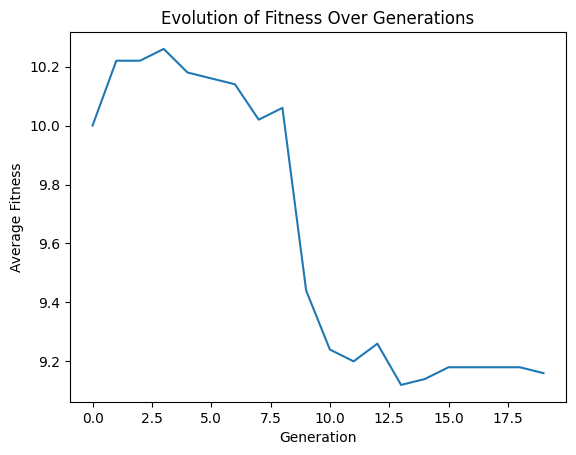

In [17]:
fitness_plot(fitness_history)

In [18]:
capacities, res_id = block_coverage(best_candidate, SERVICE_RADIUS, uncovered_demand, id_matrix)

print([num for num in capacities if num > 0])
res_id

[50.0, 69.0, 450.0, 74.0, 50.0, 50.0, 50.0, 50.0, 50.0]


{0: [0, 1],
 10: [4, 8, 9, 10],
 15: [5, 6, 7, 14, 15, 31],
 27: [19, 27, 32],
 39: [39],
 47: [47],
 53: [53],
 56: [55, 56, 57],
 65: [65]}

In [19]:
selected_potential_services = gpd.GeoDataFrame(df_with_demand.loc[:, 'geometry']).loc[list(res_id.keys()), :]
selected_potential_services['capacity'] = [capacity for capacity in capacities if capacity > 0]

arr_index = np.intersect1d(selected_potential_services.index, df_with_demand[df_with_demand['capacity']>0].index)

for i in arr_index:
    selected_potential_services.loc[i, 'capacity'] += df_with_demand.loc[i, 'capacity']

In [20]:
df_opt = df_with_demand.sjoin(selected_potential_services.to_crs(local_crs), how='left', lsuffix='osn').fillna(0)
df_opt['capacity'] = df_opt['capacity_osn'] + df_opt['capacity_right']
df_opt.drop(columns = ['capacity_osn', 'index_right', 'capacity_right'], inplace=True)

In [22]:
policlinics = gpd.read_file(os.path.join("/data/policlinics.geojson")).to_crs(local_crs)
policlinics['our_service'] = policlinics[policlinics['geometry'].notnull()]['geometry'].apply(lambda point: '+' if any(point.within(poly) for poly in df_opt.drop(arr_index)['geometry']) else '-')

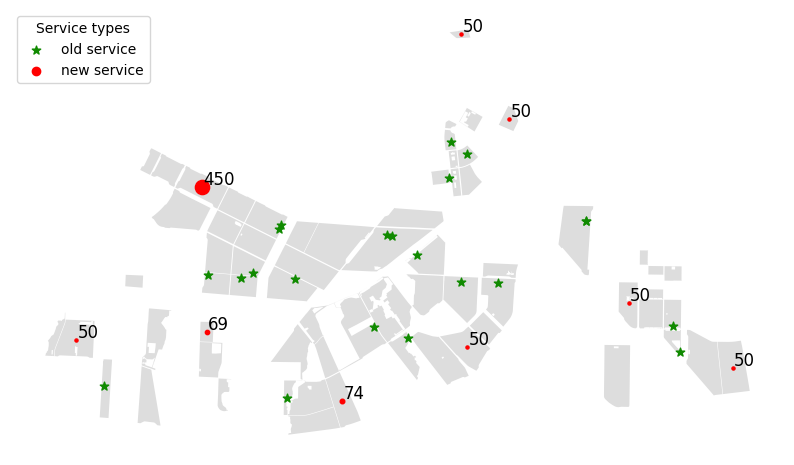

In [23]:
services_plot(df_with_demand, df_opt, res_id,
              policlinics, size_factor=100, alpha=0.05,
              size_factor_2=100, alpha_2=0.05, x=20, y=50, x_2=10, y_2=50)

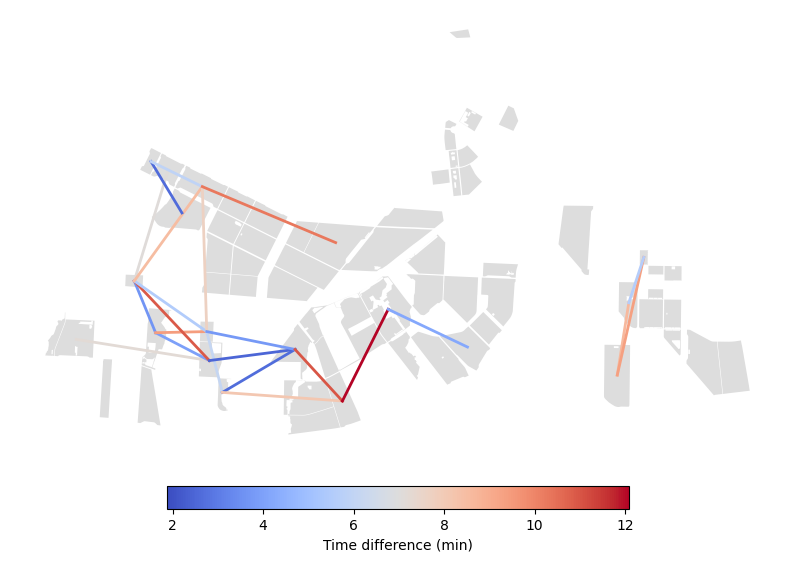

In [24]:
connect_blocks_plot(id_matrix, accessibility_matrix_uncovered_demand, df_opt, best_candidate)